# Arrival Time Prediction - Pre Processing
This notebook is the first on the work on GP regression for arrival time prediction and deals with the pre processing before a model can be trained to make predictions.

First off lets get some libraries into scope and load the data.

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
from datetime import datetime
from functools import reduce

data = pd.read_csv('../../bus203_all.csv')
data = data[data.journey_number < 10]
data.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
0,0,2018-02-16T04:48:40.0000000+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,NaN,1,1
1,1,2018-02-16T04:48:40.0000000+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1
2,2,2018-02-16T04:48:40.0000000+01:00,ArrivedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,Rydsv\xe4gens \xe4ndh\xe5llpl.,1,1
3,3,2018-02-16T04:48:41.0000000+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1
4,4,2018-02-16T04:48:42.0000000+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1


The names in the csv are very verbose, so we'll shorten them. This is of course a matter of preference but I prefer it this way.

In [2]:
data = data.rename(columns = {
                        'latitude': 'lat', 
                        'longitude': 'lon', 
                        'journey_number': 'traj', 
                        'segment_number': 'seg', 
                        'speed': 'speed', 
                        't': 't'})
data.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,lon,lat,direction,speed,station,traj,seg
0,0,2018-02-16T04:48:40.0000000+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,NaN,1,1
1,1,2018-02-16T04:48:40.0000000+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1
2,2,2018-02-16T04:48:40.0000000+01:00,ArrivedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,Rydsv\xe4gens \xe4ndh\xe5llpl.,1,1
3,3,2018-02-16T04:48:41.0000000+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1
4,4,2018-02-16T04:48:42.0000000+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1


## Computing arrival times
The goal is to estimate arrival time given a trajectory, but to do that we first need to annotate the trajectories in the data with the actual arrival times. We do this by creating a dictionary which maps trajectories to arrival times and save it for later.

In [3]:
def parse_time(dt_str):
    dt, _, _ = dt_str.partition(".")
    return datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")

def traj_travel_time(data, traj):
    traj_data = data[data.traj == traj]
    segs = traj_data.seg.unique()
    return {seg : seg_travel_time(traj_data, seg) for seg in segs}

def seg_travel_time(traj_data, seg):
    seg_data = traj_data[traj_data.seg == seg]
    start_time = parse_time(seg_data.iloc[0].timestamp)
    arrival_time = parse_time(seg_data.iloc[-1].timestamp)
    return arrival_time - start_time

t0 = time.time()
trajs = data.traj.unique()
travel_times = {traj : traj_travel_time(data, traj) for traj in trajs}
elapsed = time.time() - t0

with open('travel_times.pkl', 'wb') as handle:
    pickle.dump(travel_times, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Data processed in", elapsed, " seconds")

Data processed in 0.08128905296325684  seconds


In addition to knowing the arrival times when making predictions, we are going to need to know the _progression_ of each trajectory. This is needed to train a synchronisation GP before making the predictions. The following chunk annotates the data with normalised temporal progression. Beware that this takes a while! It took me 20 minutes on an i7 processor.

In [5]:
t0 = time.time()
progress = pd.DataFrame({'progress': np.zeros(data.size)})
reverse_rows = data.iloc[::-1]
last_stop_timestamp = parse_time(reverse_rows.iloc[0].timestamp)
for i, d in reverse_rows.iterrows():
    t = parse_time(d.timestamp)
    if d.event == 'EnteredEvent':
        last_stop_timestamp = t
    progress.iloc[i] = 1 - (((last_stop_timestamp - t).seconds) / travel_times[d.traj][d.seg].seconds)

progress_data = pd.concat([
            data['lat'], 
            data['lon'], 
            data['traj'], 
            data['seg'], 
            data['speed'], 
            progress],
            axis = 1)

print("Data processed in", elapsed, " seconds")
elapsed = time.time() - t0
progress_data[progress_data.traj == 1]

Data processed in 0.08128905296325684  seconds


,lat,lon,traj,seg,speed,progress
0,15.571015,58.414238,1.0,1.0,-1.00,0.000000
1,15.571015,58.414238,1.0,1.0,0.00,0.000000
2,15.571015,58.414238,1.0,1.0,-1.00,0.000000
3,15.571012,58.414246,1.0,1.0,0.00,0.013889
4,15.571008,58.414249,1.0,1.0,0.00,0.027778
5,15.571004,58.414257,1.0,1.0,0.00,0.041667
6,15.571006,58.414257,1.0,1.0,0.00,0.055556
7,15.571008,58.414261,1.0,1.0,0.00,0.069444
8,15.571010,58.414261,1.0,1.0,0.00,0.083333
9,15.571012,58.414261,1.0,1.0,0.00,0.097222


## Spatial downsampling
There are many times where busses stop or drive very slowly. This causes a lot of data points to be clustered which will cause the GPs to prioritise getting the clustered areas right more than other areas, which we do not want. To prevent this we will filter out data points in every trajectory that are too close by some delta. Worth noting is that coordinates are not in euclidian space but on a spherical surface so pythagoras theorem is no good here and we have to turn to haversine distance.

In [6]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    return c * r

def as_dict(d):
    return {
        'lat': d.lat,
        'lon': d.lon,
        'seg': d.seg,
        'speed': d.speed,
        'progress': d.progress,
        'traj': d.traj
    }

t0 = time.time()

# Iterate through all data points, compare with latest 
# in resampled_data and append if it the distance is larger than 
# haversine delta. We also always append the final point, to make sure
# the trajectory is always complete.
delta = 4e-3 # approx. 4 metres
rows = [as_dict(progress_data.iloc[0])]
for i, d in progress_data.iterrows():
    di = rows[len(rows)-1]
    if haversine(d.lat, d.lon, di.get('lat'), di.get('lon')) > delta or d.progress == 1:
        rows.append(as_dict(d))

resampled_data = pd.DataFrame(rows)

elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")
resampled_data

Data processed in 4.4667909145355225  seconds


,lat,lon,progress,seg,speed,traj
0,15.571015,58.414238,0.000000,1.0,-1.00,1.0
1,15.571187,58.414196,0.194444,1.0,-1.00,1.0
2,15.571016,58.414265,0.208333,1.0,0.41,1.0
3,15.571072,58.414230,0.263889,1.0,1.49,1.0
4,15.571137,58.414204,0.291667,1.0,2.31,1.0
5,15.571241,58.414196,0.319444,1.0,2.72,1.0
6,15.571343,58.414211,0.347222,1.0,2.77,1.0
7,15.571423,58.414249,0.375000,1.0,2.82,1.0
8,15.571444,58.414303,0.402778,1.0,2.77,1.0
9,15.571422,58.414360,0.430556,1.0,2.82,1.0


## Filter outlier
Plotting the data show one outlier, how it got there is beyond me, but we filter it out.

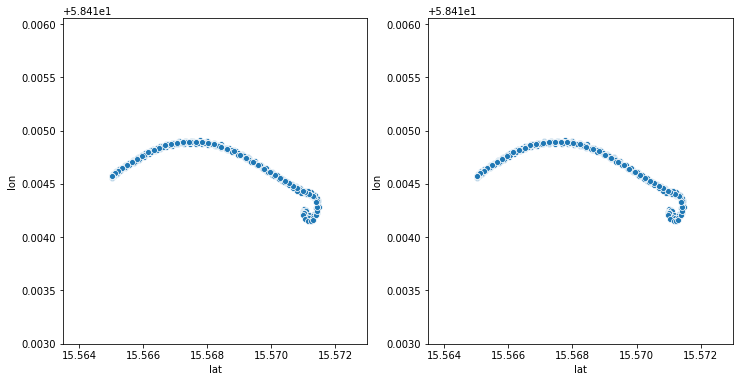

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
seg = resampled_data[resampled_data.seg == 1]
sns.scatterplot(x="lat", y="lon", data=seg, ax=ax[0])

d = resampled_data # just a shorted name for the query
filtered_data = d[((d.lat > 15.562) & (d.seg == 1)) | (d.seg != 1)]       
seg = filtered_data[filtered_data.seg == 1]
sns.scatterplot(x="lat", y="lon", data=seg, ax=ax[1])

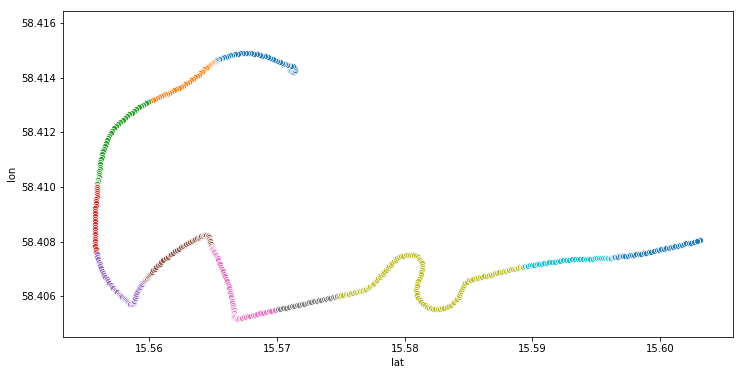

In [10]:
def plot_traj(traj_n):
    traj_one = filtered_data[filtered_data.traj == traj_n]
    segs = traj_one.seg.unique()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    for seg_n in segs:
        seg = traj_one[traj_one.seg == seg_n]
        sns.scatterplot(x="lat", y="lon", data=seg, ax=ax)
plot_traj(1)

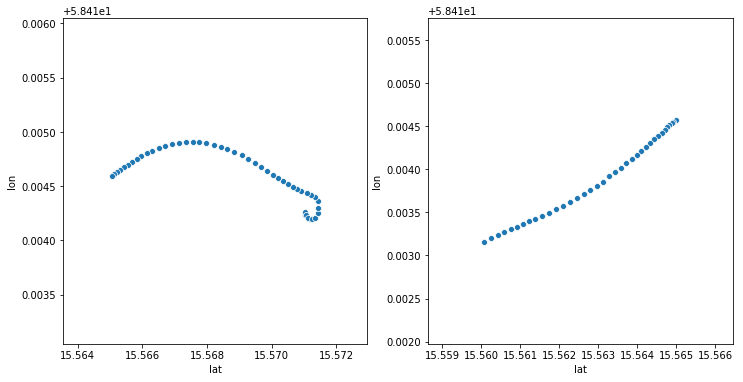

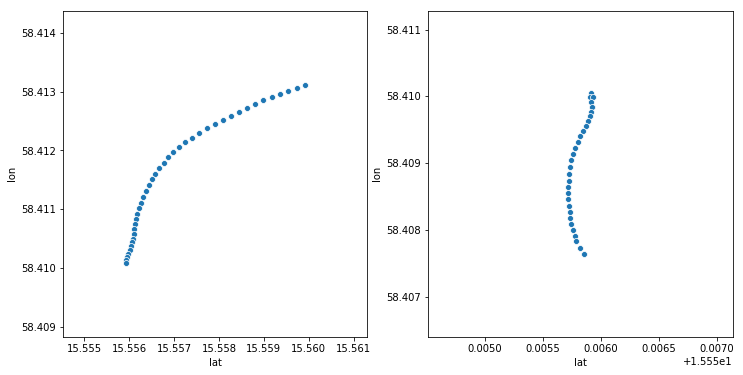

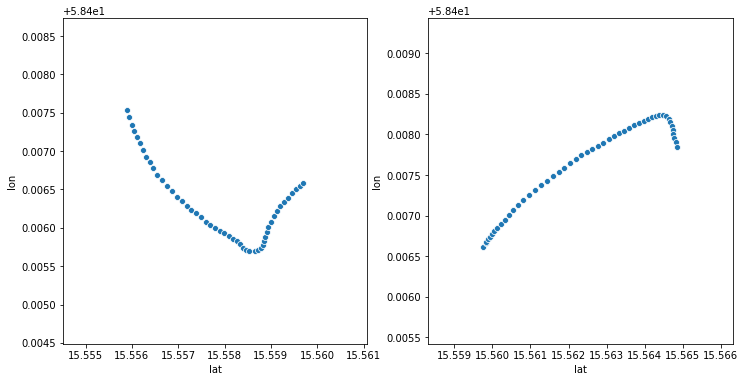

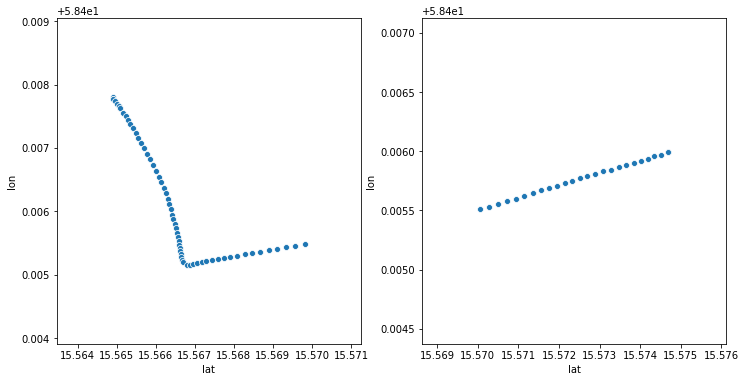

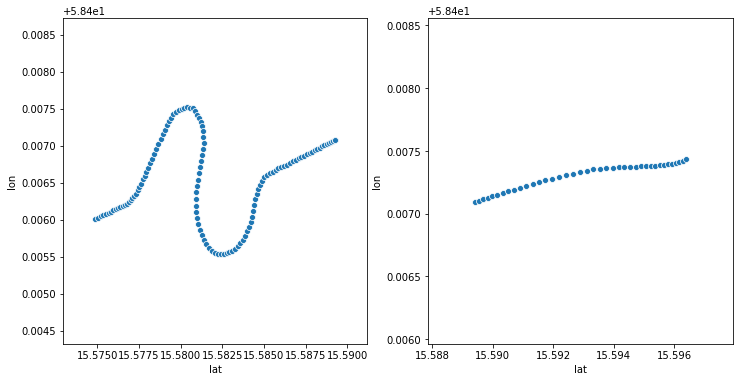

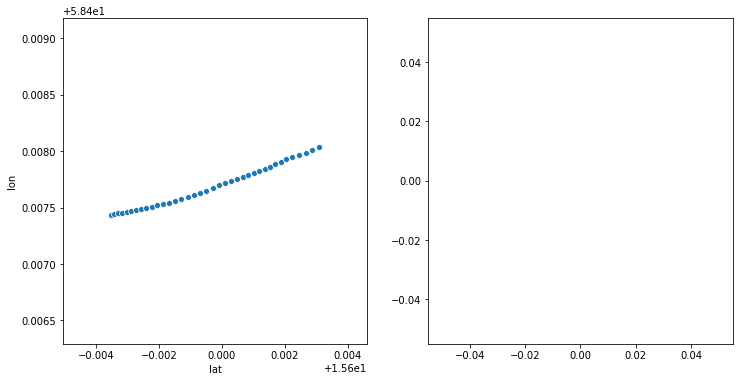

In [13]:
def plot_traj_segments(traj_n): 
    traj = filtered_data[filtered_data.traj == traj_n]
    segs = traj.seg.unique()
    n_cols = 2
    n_segs = len(segs)
    n_rows = ceil(n_segs/n_cols)
    for n in range(1, n_segs+1, 2):
        fig, ax = plt.subplots(nrows=1, ncols=n_cols, figsize=(12, 6))
        seg1 = traj[traj.seg == n]
        sns.scatterplot(x="lat", y="lon", data=seg1, ax=ax[0])
        seg2 = traj[traj.seg == n+1]    
        sns.scatterplot(x="lat", y="lon", data=seg2, ax=ax[1])
plot_traj_segments(1)

## Enforce smoothness
A property that we want from the synchroinisation GP that we will train is for it to be a smooth mapping with respect to spatial progress, that is, we want regions that are close progressionwise in the functions domain to be close in its codomain. This is not something a GP guarantees at all, so to force it to learn something closer to what we want the data is duplicated with a small offset orthogonal to progression.

C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


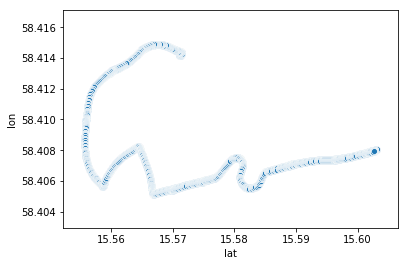

In [15]:
from numpy.linalg import norm
tmp_data = []
N = filtered_data.shape[0]
for n in range(N-1):
    cur = filtered_data.iloc[n]
    nxt = filtered_data.iloc[n+1]
    d_lat = nxt.lat - cur.lat
    d_lon = nxt.lon - cur.lon
    
    d = 4e-5
    v = np.array([nxt.lat - cur.lat, nxt.lon - cur.lon])
    v = d*v/norm(v)   # sane scale
    u = [-v[1], v[0]] #orthogonal to progression 
    
    d1 = cur.copy()
    d1.lat = d1.lat - u[0]
    d1.lon = d1.lon + u[1]
    
    d2 = cur.copy()
    d2.lat = d2.lat + u[0]
    d2.lon = d2.lon - u[1]
    
    tmp_data.append(cur)
    tmp_data.append(d1)
    tmp_data.append(d2)
    
duplicated_data = pd.DataFrame(tmp_data)
sns.scatterplot(x="lat", y="lon", data=duplicated_data)

Finally let's pickle the data into a test and training set. After this we'll be ready to train the synchronisation GPs!

In [16]:
n_trajs = len(duplicated_data.traj.unique())
n_train = round(n_trajs*0.8)
train_ixs = frozenset(np.random.randint(0, n_trajs-1, n_train))

train_trajs = duplicated_data[duplicated_data.traj.transform(lambda x: x in train_ixs)]
test_trajs = duplicated_data[duplicated_data.traj.transform(lambda x: x not in train_ixs)]
train_trajs.to_pickle('train.pkl')
test_trajs.to_pickle('test.pkl')

In [17]:
train_ixs

frozenset({2, 3, 4, 5, 7})